# Simple prediction of stock price using LR and DTR

In [604]:
# Importing key libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("bmh")
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import  mean_squared_error, r2_score

In [605]:
# Downloading data
xtb = pd.read_csv("Data/xtb_d.csv", index_col="Data", parse_dates=True)
wig = pd.read_csv("Data/wig_d.csv", index_col="Data", parse_dates=True)
vix = pd.read_csv("Data/vix20_f_d.csv", index_col="Data", parse_dates=True)

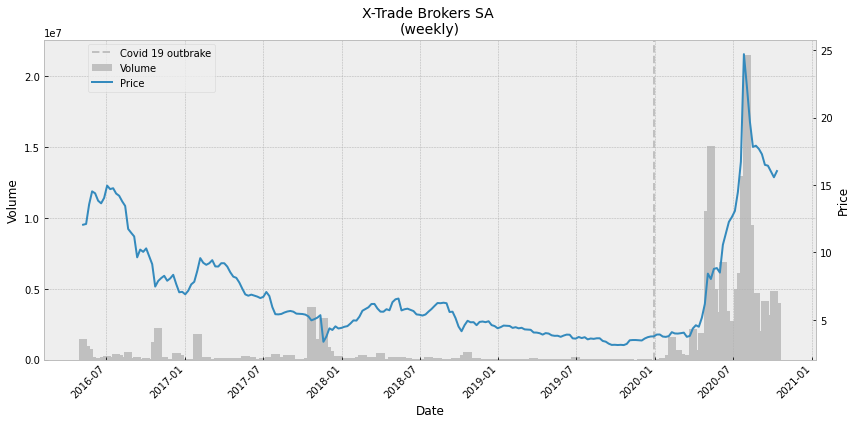

In [606]:
# Plotting the closing price and volume, weekly view
price = xtb.Zamkniecie.resample("W").mean()
volume = xtb.Wolumen.resample("W").sum()

fig, ax = plt.subplots(figsize=(12,6))
fig.autofmt_xdate(rotation=45)

ax.bar(volume.index, volume, color="silver", width=20)
ax.set(xlabel="Date", ylabel="Volume", yscale="linear")
ax.set_title(label="X-Trade Brokers SA \n(weekly)", fontsize=14)
ax.axvline("2019-12-30", color="silver", linestyle="--", linewidth=2)

ax2 = ax.twinx()
ax2.plot(price.index, price, linewidth=2)
ax2.set(ylabel="Price", yscale="linear")

fig.legend(["Covid 19 outbrake", "Volume", "Price"], loc="upper left", bbox_to_anchor=(0.1, 0.9))

plt.grid()
plt.tight_layout()
plt.show()

In [607]:
# constructing dataset
dataset = pd.concat([xtb["Zamkniecie"], wig["Zamkniecie"], vix["Zamkniecie"]], axis=1).dropna()
dataset.columns = ["xtb", "wig", "vix"]
dataset.head()

,xtb,wig,vix
Data,,,
2019-12-09,3.84000,55867.95,19.125
2019-12-10,3.63000,55609.32,19.450
2019-12-11,3.65003,55531.27,19.475
2019-12-12,3.69000,56621.06,19.125
2019-12-13,3.75000,56729.11,18.975


In [619]:
# Correlation between variables
dataset.corr()

,xtb,wig,vix
xtb,1.000000,-0.016087,0.641799
wig,-0.016087,1.000000,-0.682630
vix,0.641799,-0.682630,1.000000


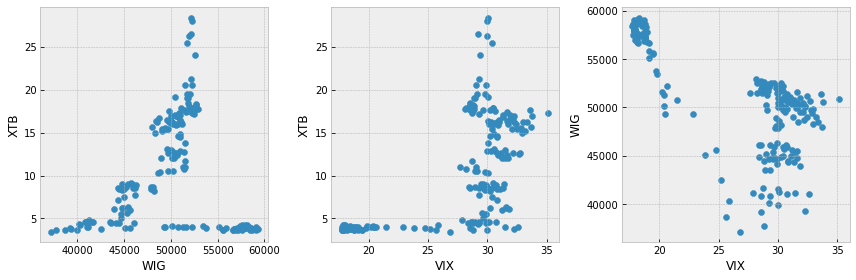

In [633]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

ax[0].scatter(x=dataset.wig.values, y=dataset.xtb.values)
ax[0].set(xlabel="WIG", ylabel="XTB")
ax[1].scatter(x=dataset.vix.values, y=dataset.xtb.values)
ax[1].set(xlabel="VIX", ylabel="XTB")
ax[2].scatter(x=dataset.vix.values, y=dataset.wig.values)
ax[2].set(xlabel="VIX", ylabel="WIG")

plt.tight_layout()
plt.show()

In [608]:
# Chosing features and labels
labels = dataset["xtb"].values
features = dataset.drop("xtb", axis=1).values

In [609]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [610]:
# Aplying Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)

In [611]:
# Measuring LR results

print("MSE: %.4f" % mean_squared_error(y_test, predictions))
print("RMSE: %.4f" % (np.sqrt(mean_squared_error(y_test, predictions))))
print('R2: %.4f' % r2_score(y_test, predictions))

MSE: 11.3075
RMSE: 3.3627
R2: 0.7154


In [612]:
# Measuring DTR results
dtr = DecisionTreeRegressor()
dtr.fit(X_train, y_train)
predictions = dtr.predict(X_test)

In [613]:
# Measuring DTR results
print("MSE: %.4f" % mean_squared_error(y_test, predictions))
print("RMSE: %.4f" % (np.sqrt(mean_squared_error(y_test, predictions))))
print('R2: %.4f' % r2_score(y_test, predictions))

MSE: 4.3451
RMSE: 2.0845
R2: 0.8906


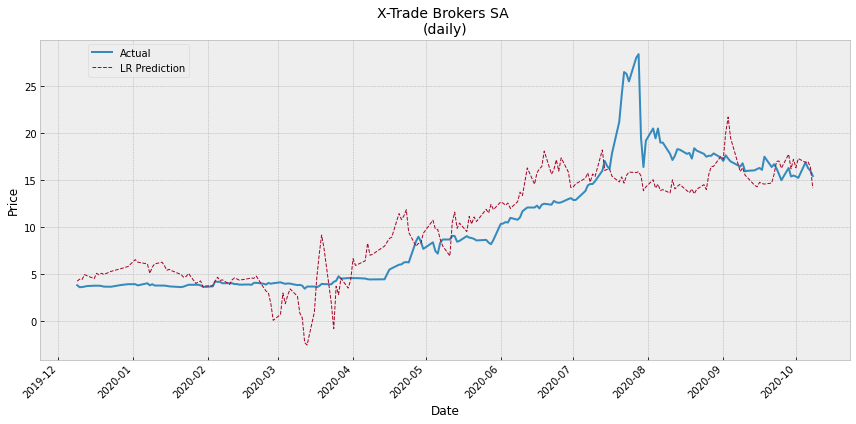

In [614]:
# Plotting LR results
fig, ax = plt.subplots(figsize=(12,6))
fig.autofmt_xdate(rotation=45)

ax.set(xlabel="Date", ylabel="Price", yscale="linear")
ax.set_title(label="X-Trade Brokers SA \n(daily)", fontsize=14)

ax.plot(dataset.index, dataset.xtb, linewidth=2)
ax.plot(dataset.index, pd.Series(lr.predict(dataset.drop("xtb",axis=1).values)), linewidth=1, ls="--")

fig.legend(["Actual", "LR Prediction", "DTR Prediction"], loc="upper left", bbox_to_anchor=(0.1, 0.9))

plt.tight_layout()
plt.show()

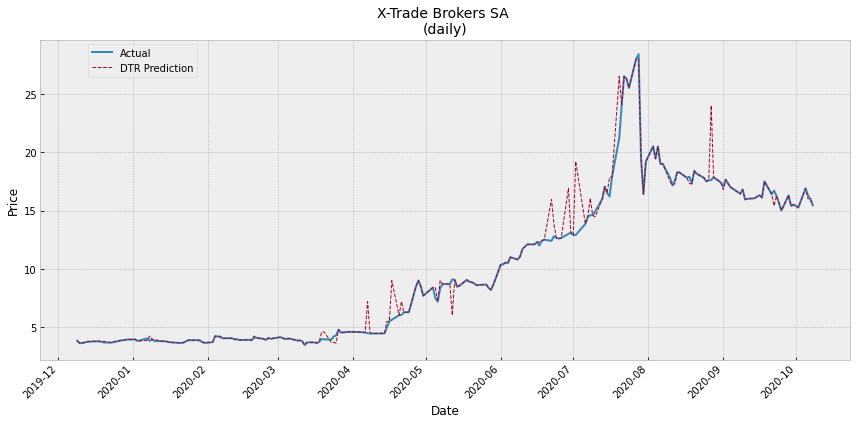

In [615]:
# Plotting DTR results
fig, ax = plt.subplots(figsize=(12,6))
fig.autofmt_xdate(rotation=45)

ax.set(xlabel="Date", ylabel="Price", yscale="linear")
ax.set_title(label="X-Trade Brokers SA \n(daily)", fontsize=14)

ax.plot(dataset.index, dataset.xtb, linewidth=2)
ax.plot(dataset.index, pd.Series(dtr.predict(dataset.drop("xtb",axis=1).values)), linewidth=1, ls="--")

fig.legend(["Actual", "DTR Prediction"], loc="upper left", bbox_to_anchor=(0.1, 0.9))

plt.tight_layout()
plt.show()